## 01 — FDA Drug Approvals (NDA VS BLA, 2010–2024)

Columns: ['Proprietary  Name', 'Active Ingredient/Moiety', 'Applicant', 'NDA/BLA', 'Application Number(1)', 'Application Number(2)', 'Application Number(3)', 'Dosage Form(1)', 'Route of Administration(1)', 'Dosage Form(2)', 'Route of Administration(2)', 'Dosage Form(3)', 'Route of Administration(3)', 'FDA Receipt Date', 'FDA Approval Date', 'Approval Year', 'Abbreviated Indication(s)', 'Approved Use(s)', 'Review Designation', 'Orphan Drug Designation', 'Accelerated Approval', 'Breakthrough Therapy Designation', 'Fast Track Designation', 'Qualified Infectious Disease Product', 'Issued a Priority Review Voucher', 'Redeemed a Priority Review Voucher', 'Notes']
Detected category column: NDA/BLA  (matches: 623)
Sample unique values of category column: ['BLA' 'NDA']

✅ NDA vs BLA approvals per year (official CSV):


,NDA,BLA,Total,BLA Share (%)
2010,13,8,21,38.1
2011,24,6,30,20.0
2012,32,7,39,17.9
2013,25,2,27,7.4
2014,30,11,41,26.8
2015,32,13,45,28.9
2016,14,8,22,36.4
2017,34,12,46,26.1
2018,42,17,59,28.8
2019,38,10,48,20.8


Saved: figures + CSV (with 2010–2024 Total row)


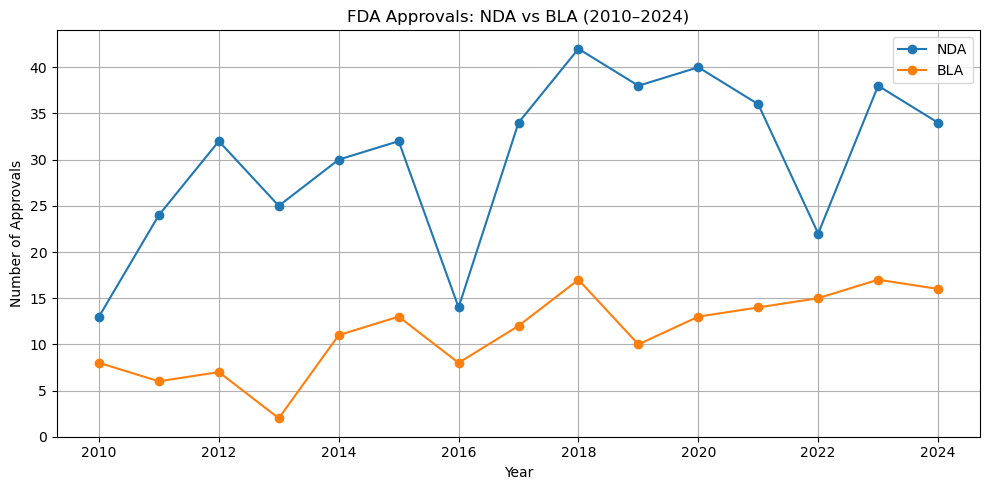

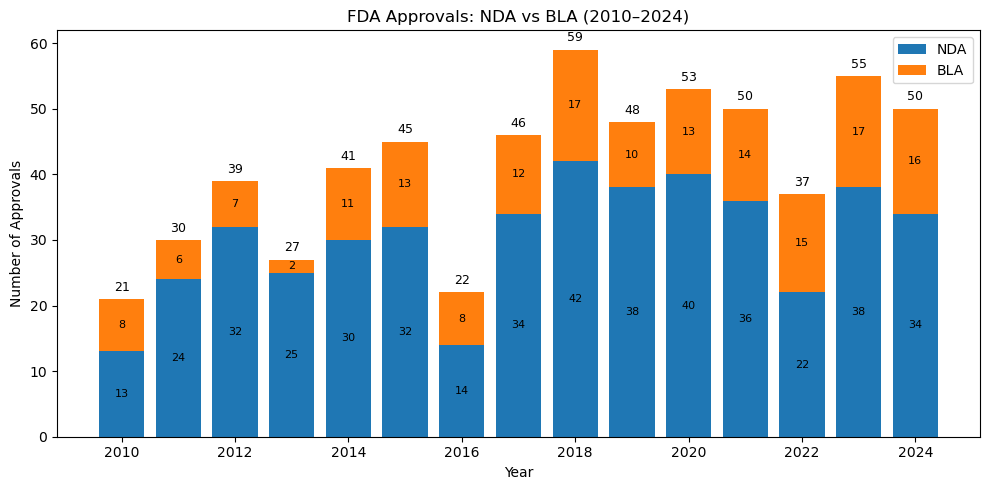

In [87]:
# --- 01: FDA Approvals (NDA vs BLA), 2010–2024 ---

from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

BASE_DIR = Path("/Users/Hanjing1/JupyterProjects/fda-drug-approvals-analysis")
DATA_DIR = BASE_DIR / "data"
FIG_DIR  = BASE_DIR / "figures"; FIG_DIR.mkdir(exist_ok=True)

CSV_IN = DATA_DIR / "final for posting compilation_of_cder_nme_and_new_biologic_approvals_1985-2024.csv"
START_YEAR, END_YEAR = 2010, 2024

# 1) Load and normalize columns
df = pd.read_csv(CSV_IN)
df.columns = df.columns.str.strip()
print("Columns:", list(df.columns))

# 2) Detect the approval year column
year_col = None
for c in df.columns:
    lc = c.lower()
    if "year" in lc and "approval" in lc:
        year_col = c
        break
if year_col is None:
    for c in df.columns:
        if "year" in c.lower():
            year_col = c
            break
if year_col is None:
    raise ValueError("Could not find the year column (e.g., 'Approval Year').")

df[year_col] = pd.to_numeric(df[year_col], errors="coerce")
df = df[df[year_col].between(START_YEAR, END_YEAR)].copy()

# 3) Auto-detect the column that contains NME/BLA (or synonyms)
#    We look for tokens in upper-cased text: BLA, BIOLOGIC(S), NME, NEW MOLECULAR, NDA, NEW DRUG
tokens_bla = ["BLA", "BIOLOGIC", "BIOLOGICS"]
tokens_nme = ["NME", "NEW MOLECULAR", "NDA", "NEW DRUG"]

def count_hits(series):
    s = series.astype(str).str.upper()
    hits = 0
    for t in tokens_bla + tokens_nme:
        hits += s.str.contains(t).sum()
    return hits

cat_col = None
best_hits = 0
for c in df.columns:
    hits = count_hits(df[c])
    if hits > best_hits:
        best_hits = hits
        cat_col = c

if cat_col is None or best_hits == 0:
    raise ValueError("Could not find any column containing NME/BLA (or Biologic/NDA) markers.")

print(f"Detected category column: {cat_col}  (matches: {best_hits})")
print("Sample unique values of category column:", df[cat_col].dropna().astype(str).str.upper().unique()[:12])

# 4) Build a clean 'DisplayCat' = {'NDA', 'BLA'}
def to_display_cat(x):
    v = str(x).upper()
    if any(tok in v for tok in tokens_bla):
        return "BLA"
    if any(tok in v for tok in tokens_nme):
        return "NDA"   # show NME as NDA (label only)
    return None

df["DisplayCat"] = df[cat_col].apply(to_display_cat)

# Fallback: if any rows are still None, try to infer from an application-number-like column
if df["DisplayCat"].isna().any():
    app_cols = [c for c in df.columns if ("application" in c.lower() and "number" in c.lower()) or c.lower() in {"applno", "appl no"}]
    if app_cols:
        s = df[app_cols[0]].astype(str).str.upper().str.strip()
        df.loc[df["DisplayCat"].isna() & s.str.startswith("BLA"), "DisplayCat"] = "BLA"
        df.loc[df["DisplayCat"].isna() & ~s.str.startswith("BLA"), "DisplayCat"] = "NDA"

# As a final guard, fill anything unknown as NDA (rare)
df["DisplayCat"] = df["DisplayCat"].fillna("NDA")

# 5) Aggregate by year & category
pivot = (
    df.groupby([year_col, "DisplayCat"])
      .size().reset_index(name="Approvals")
      .pivot(index=year_col, columns="DisplayCat", values="Approvals")
      .fillna(0).astype(int).sort_index()
)

# Ensure both columns exist and set order
for col in ["NDA", "BLA"]:
    if col not in pivot.columns:
        pivot[col] = 0
pivot = pivot[["NDA", "BLA"]]

# Add totals and BLA share (per year)
out_table = pivot.copy()
out_table["Total"] = out_table["NDA"] + out_table["BLA"]
out_table["BLA Share (%)"] = (out_table["BLA"] / out_table["Total"] * 100).round(1)

# ---- NEW: add one overall summary row for 2010–2024 ----
total_nda = out_table["NDA"].sum()
total_bla = out_table["BLA"].sum()
total_all = total_nda + total_bla
total_bla_share = (total_bla / total_all * 100).round(1)

summary_row = pd.DataFrame(
    {
        "NDA": [total_nda],
        "BLA": [total_bla],
        "Total": [total_all],
        "BLA Share (%)": [total_bla_share],
    },
    index=[f"{START_YEAR}-{END_YEAR} Total"]
)

out_table_with_total = pd.concat([out_table, summary_row])

print("\n✅ NDA vs BLA approvals per year (official CSV):")
display(out_table_with_total)

# 6) Line chart  (use yearly data only, without the Total row)
plt.figure(figsize=(10,5))
plt.plot(out_table.index, out_table["NDA"], marker="o", label="NDA")
plt.plot(out_table.index, out_table["BLA"], marker="o", label="BLA")
plt.title("FDA Approvals: NDA vs BLA (2010–2024)")
plt.xlabel("Year"); plt.ylabel("Number of Approvals")
plt.grid(True); plt.legend(); plt.tight_layout()
plt.savefig(FIG_DIR / "nda_vs_bla_line_2010_2024_auto.png", dpi=150)

# 7) Stacked bar chart with labels (also using yearly rows only)
plt.figure(figsize=(10,5))
years = out_table.index
nda = out_table["NDA"]
bla = out_table["BLA"]
total = out_table["Total"]

plt.bar(years, nda, label="NDA")
plt.bar(years, bla, bottom=nda, label="BLA")
for x, n, b, t in zip(years, nda, bla, total):
    if n > 0: plt.text(x, n/2, f"{n}", ha="center", va="center", fontsize=8)
    if b > 0: plt.text(x, n + b/2, f"{b}", ha="center", va="center", fontsize=8)
    plt.text(x, t + 0.8, f"{t}", ha="center", va="bottom", fontsize=9)

plt.title("FDA Approvals: NDA vs BLA (2010–2024)")
plt.xlabel("Year"); plt.ylabel("Number of Approvals")
plt.legend(); plt.tight_layout()
plt.savefig(FIG_DIR / "nda_vs_bla_stacked_2010_2024_auto.png", dpi=150)

# 8) Save CSV (including the total row)
out_table_with_total.to_csv(BASE_DIR / "nda_vs_bla_2010_2024_auto.csv")
print("Saved: figures + CSV (with 2010–2024 Total row)")



## 02 — FDA Drug Approvals by Therapeutic Area (2010–2024)

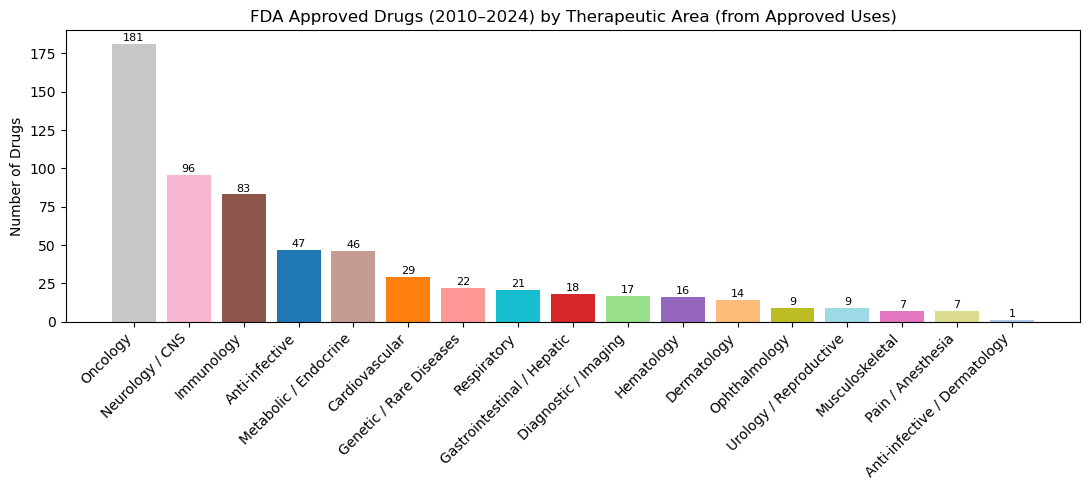

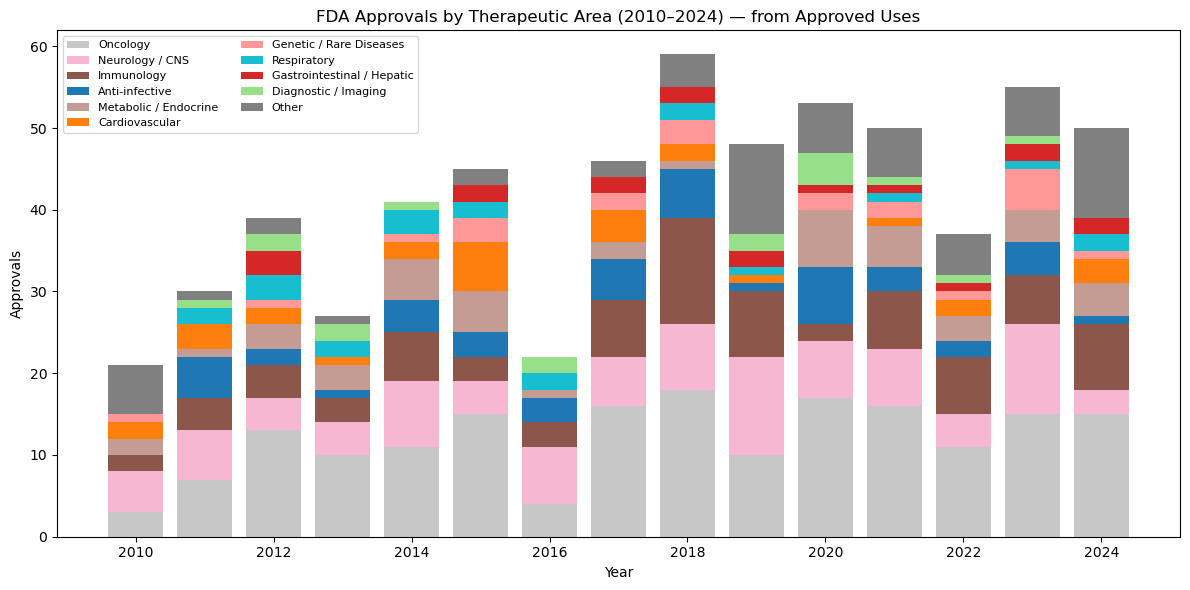


=== Therapeutic Area Distribution (2010–2024) ===


,Therapeutic Area,Drug Count
0,Oncology,181
1,Neurology / CNS,96
2,Immunology,83
3,Anti-infective,47
4,Metabolic / Endocrine,46
5,Cardiovascular,29
6,Genetic / Rare Diseases,22
7,Respiratory,21
8,Gastrointestinal / Hepatic,18
9,Diagnostic / Imaging,17



Unmapped drugs: 0 / 623 (0.0%)

Saved:
  • Overall labeled bar chart: /Users/Hanjing1/JupyterProjects/fda-drug-approvals-analysis/figures/ta_overall_2010_2024_labeled.png
  • Stacked yearly chart: /Users/Hanjing1/JupyterProjects/fda-drug-approvals-analysis/figures/ta_stacked_by_year_2010_2024.png
  • Therapeutic area counts CSV: /Users/Hanjing1/JupyterProjects/fda-drug-approvals-analysis/figures/therapeutic_area_counts_2010_2024.csv


In [88]:
## 02 — FDA Drug Approvals by Therapeutic Area (2010–2024)

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---- 0) Sanity checks & filter for 2010–2024 ----
assert 'df' in globals(), "Please run Module 01 first so that `df` is defined."
assert 'year_col' in globals() and year_col in df.columns, "`year_col` is not defined or missing in df."
assert 'FIG_DIR' in globals(), "`FIG_DIR` is not defined."

df2 = df.copy()
df2[year_col] = pd.to_numeric(df2[year_col], errors="coerce")
df2 = df2[df2[year_col].between(2010, 2024)].copy()

# ---- 1) Choose indication text: prefer Approved Use(s), fallback to Abbreviated Indication(s) ----
def choose_use_text(row):
    """Prefer 'Approved Use(s)'; if empty, fallback to 'Abbreviated Indication(s)'."""
    a = row.get("Approved Use(s)")
    b = row.get("Abbreviated Indication(s)")
    a = None if (pd.isna(a) or str(a).strip() == "") else str(a)
    b = None if (pd.isna(b) or str(b).strip() == "") else str(b)
    return a if a is not None else b

if "Approved Use(s)" not in df2.columns and "Abbreviated Indication(s)" not in df2.columns:
    raise ValueError("Neither 'Approved Use(s)' nor 'Abbreviated Indication(s)' exists in the CSV.")

df2["Use_Text"] = df2.apply(choose_use_text, axis=1).fillna("")

# ---- 2) Basic text preprocessing ----
def prep_text(s: str) -> str:
    """Lowercase and lightly normalize indication text for regex matching."""
    s = str(s).lower()
    s = re.sub(r"[()\[\]]", " ", s)      # remove brackets
    s = re.sub(r"[/|]", " ", s)         # normalize separators
    s = re.sub(r"\s+", " ", s).strip()  # collapse whitespace
    return s

df2["_ind_text"] = df2["Use_Text"].map(prep_text)

# ---- 3) Keyword → therapeutic area mapping ----
# Order: specific patterns first; broad base rules later.
keyword_map = [
    # ---------- Very specific metabolic / endocrine ----------
    (r"cushing'?s disease|cushing'?s syndrome", "Metabolic / Endocrine"),
    (r"primary hyperoxaluria type 1|primary hyperoxaluria|ph1\b", "Metabolic / Endocrine"),
    (r"long-chain fatty acid oxidation disorders?|lc-faod|faod", "Metabolic / Endocrine"),
    (r"congenital adrenal hyperplasia|ca[hH]\b", "Metabolic / Endocrine"),
    (r"hyperuricemia|uric acid|gout", "Metabolic / Endocrine"),
    (r"chylomicronemia|familial chylomicronemia syndrome", "Metabolic / Endocrine"),

    # ---------- Very specific hematology ----------
    (r"paroxysmal nocturnal hemoglobinuria|pnh", "Hematology"),
    (r"iron deficiency", "Hematology"),
    (r"cold agglutinin disease|cad\b", "Hematology"),

    # ---------- Neurology / CNS (specific diseases) ----------
    (r"huntington", "Neurology / CNS"),
    (r"chorea", "Neurology / CNS"),
    (r"insomnia", "Neurology / CNS"),
    (r"neuromyelitis optica spectrum disorder|neuromyelitis optica|nmosd", "Neurology / CNS"),
    (r"myasthenia gravis|gmg", "Neurology / CNS"),
    (r"rett syndrome", "Neurology / CNS"),
    (r"friedreich", "Neurology / CNS"),
    (r"depression|depressive disorder|major depressive disorder|mdd", "Neurology / CNS"),
    (r"restless legs syndrome|rls\b|postherpetic neuralgia|neuropathic pain|"
     r"non-24-hour sleep-wake|non-24-hour sleep wake|narcolepsy|excessive daytime sleepiness",
     "Neurology / CNS"),

    # ---------- Oncology: hematologic & brain tumors / NF1 ----------
    (r"mycosis fungoides|sezary syndrome", "Oncology"),
    (r"blastic plasmacytoid dendritic cell neoplasm|bpdcn", "Oncology"),
    (r"neurofibromatosis type 1|nf1\b|plexiform neurofibromas?", "Oncology"),
    (r"low-grade glioma|lgg\b|astrocytoma|oligodendroglioma|braf fusion|braf v600", "Oncology"),

    # ---------- Immunology / immune-mediated ----------
    (r"hemophagocytic lymphohistiocytosis|hlh", "Immunology"),
    (r"graft[- ]versus[- ]host|gvhd|graft versus host", "Immunology"),
    (r"activated phosphoinositide 3-kinase delta syndrome|apds", "Immunology"),
    (r"hereditary angioedema|hae\b", "Immunology"),
    (r"antineutrophil cytoplasmic autoantibody|anca-associated vasculitis|gpa\b|mpa\b",
     "Immunology"),

    # ---------- Genetic / rare diseases ----------
    (r"progeroid laminopathies|progeria|hutchinson-gilford|hgps", "Genetic / Rare Diseases"),
    (r"molybdenum cofactor deficiency|mocd", "Genetic / Rare Diseases"),
    (r"acid sphingomyelinase deficiency|asmd", "Genetic / Rare Diseases"),
    (r"fabry disease", "Genetic / Rare Diseases"),
    (r"alpha-mannosidosis", "Genetic / Rare Diseases"),
    (r"cd55-deficient protein-losing enteropathy|chaple disease", "Genetic / Rare Diseases"),
    (r"lysosomal storage", "Genetic / Rare Diseases"),

    # ---------- GI / hepatic, specific syndromes & bowel prep ----------
    (r"carcinoid syndrome diarrhea", "Gastrointestinal / Hepatic"),
    (r"bowel preparation|bowel prep|colon cleansing|cleansing of the colon|colonoscopy preparation",
     "Gastrointestinal / Hepatic"),
    (r"short bowel syndrome", "Gastrointestinal / Hepatic"),
    (r"hepatorenal syndrome", "Gastrointestinal / Hepatic"),
    (r"alagille syndrome|cholestatic pruritus", "Gastrointestinal / Hepatic"),
    (r"parenteral nutrition-associated cholestasis|cholestasis associated with parenteral nutrition",
     "Gastrointestinal / Hepatic"),
    (r"chronic idiopathic constipation|ibs\-c|ibs c", "Gastrointestinal / Hepatic"),

    # ---------- Anti-infective: parasites, fungi, protozoa, malaria, lice ----------
    (r"fascioliasis|fasciola hepatica", "Anti-infective"),
    (r"human african trypanosomiasis|trypanosomiasis|brucei gambiense", "Anti-infective"),
    (r"malaria", "Anti-infective"),
    (r"candidiasis|candidemia|invasive candidiasis|vulvovaginal candidiasis|vvc\b", "Anti-infective"),
    (r"head lice|pediculosis", "Anti-infective"),
    (r"onchocerciasis|onchocerca volvulus|river blindness", "Anti-infective"),

    # ---------- Dermatology / skin / cosmetic ----------
    (r"prurigo nodularis", "Dermatology"),
    (r"submental fat", "Dermatology"),
    (r"glabellar lines|glabellar", "Dermatology"),
    (r"molluscum contagiosum", "Dermatology"),
    (r"epidermolysis bullosa", "Dermatology"),
    (r"pruritus", "Dermatology"),
    (r"actinic keratosis", "Dermatology"),

    # ---------- Musculoskeletal / skeletal dysplasia ----------
    (r"fibrodysplasia ossificans progressiva|fop\b", "Musculoskeletal"),
    (r"achondroplasia", "Musculoskeletal"),
    (r"dupuytren|peyronie", "Musculoskeletal"),

    # ---------- Ophthalmology specific ----------
    (r"demodex blepharitis|blepharitis", "Ophthalmology"),
    (r"allergic conjunctivitis|ocular itching|itching associated with allergic", "Ophthalmology"),

    # ---------- Diagnostic / imaging (MRI/PET agents) ----------
    (r"positron emission tomography|pet myocardial perfusion imaging|myocardial perfusion imaging",
     "Diagnostic / Imaging"),
    (r"xenon xe 129|lung ventilation", "Diagnostic / Imaging"),
    (r"gadolinium-based contrast agent|gadolinium based contrast agent|"
     r"contrast agent for magnetic resonance imaging|mri contrast",
     "Diagnostic / Imaging"),

    # ---------- Pain / anesthesia / perioperative ----------
    (r"postoperative nausea and vomiting|ponv", "Pain / Anesthesia"),
    (r"procedural sedation", "Pain / Anesthesia"),
    (r"reversal of neuromuscular blockade|neuromuscular blockade", "Pain / Anesthesia"),

    # ---------- Women’s health / contraception ----------
    (r"contracept|prevent pregnancy|heavy menstrual bleeding|menorrhagia", "Urology / Reproductive"),

    # ---------- Broad base rules (catch-all within each area) ----------
    # Oncology (including common tumor acronyms)
    (r"oncolog|cancer|tumou?r|carcinoma|sarcoma|lymphoma|leukem|myeloma|melanoma|"
     r"nsclc|sclc|hcc|rcc|hnscc|dlbcl|follicular lymphoma|mm\b|mcl\b|aml\b|mds\b|mcrc|"
     r"ovarian|prostate cancer|breast cancer|gastric cancer|pancreatic cancer|mmr-d|msi-h",
     "Oncology"),

    # Immunology / Autoimmune (broad)
    (r"autoimmune|psoriasis|psoriatic|lupus|sle\b|ankylosing spondyl|hidradenitis|"
     r"atopic dermatitis|ra\b|rheumatoid arthritis|spondyloarth|immun", "Immunology"),

    # Metabolic / Endocrine (broad)
    (r"diabetes|t2d|t1d|glycemic|metabolic|obesity|weight management|hyperlip|lipid|"
     r"cholesterol|thyroid|insulin|glucose|nash|nafld", "Metabolic / Endocrine"),

    # Cardiovascular
    (r"cardio|hypertension|blood pressure|angina|atrial fibrillation|arrhythm|heart failure|"
     r"cv risk|pah\b|thromb|anticoagul", "Cardiovascular"),

    # Respiratory
    (r"asthma|copd|bronch|respirat|pulmon|cystic fibrosis|cf\b", "Respiratory"),

    # Neurology / CNS (broad)
    (r"seizure|epilep|parkinson|alzheimer|dementia|migraine|anxiety|adhd|"
     r"schizophren|neuropath|sma\b|multiple sclerosis|ms\b|als\b", "Neurology / CNS"),

    # Anti-infective (broad, viral/bacterial/fungal)
    (r"infection|infective|antibiotic|antiviral|antifung|hiv|aids|hepatitis b|hbv|hepatitis c|hcv|"
     r"influenza|covid|sars-cov-2|rsv|cmv|hsv|ebv|bacterial|fungal|viral", "Anti-infective"),

    # Gastrointestinal / Hepatic (broad)
    (r"ibd|ulcerative colitis|crohn'?s|ibs\b|gastro|hepatic|liver|pancrea|eoe\b|eosinophilic esophagitis",
     "Gastrointestinal / Hepatic"),

    # Hematology (broad)
    (r"anemia|hemophilia|thalassem|sickle|myelofibrosis|polycythemia|platelet|aplastic", "Hematology"),

    # Ophthalmology (broad)
    (r"ophthalm|retina|retinal|macular|n?amd\b|dme\b|diabetic macular edema|glaucoma|uveit",
     "Ophthalmology"),

    # Dermatology (broad)
    (r"dermat|skin|eczema|acne|vitiligo|alopecia", "Dermatology"),

    # Urology / Reproductive (broad)
    (r"urolog|bph\b|overactive bladder|oab\b|endometriosis|uterine|menopause|fertility|"
     r"ovary|ovarian (?!cancer)|prostate (?!cancer)", "Urology / Reproductive"),

    # Genetic / Rare Diseases (broad)
    (r"rare disease|genetic|enzyme replacement|lysosomal|duchenne|dmd\b|pompe|mps\b|"
     r"wilson'?s|amyloido|gaucher", "Genetic / Rare Diseases"),

    # Pain / Anesthesia (broad)
    (r"pain|analges|anesth|opioid|nocicept", "Pain / Anesthesia"),

    # Musculoskeletal (broad)
    (r"osteopor|bone|musculo|skeletal|osteogenesis", "Musculoskeletal"),

    # Allergy / ENT (broad)
    (r"allergy|allergic rhinitis|sinus", "Allergy / ENT"),
]

def classify(text: str) -> str:
    """Classify indication text into a therapeutic area based on keyword_map."""
    if not text:
        return "Unmapped"
    for pat, label in keyword_map:
        if re.search(pat, text):
            return label
    return "Unmapped"

df2["Therapeutic_Area"] = df2["_ind_text"].map(classify)

# ---- 4) Manual override for the last 16 previously-unmapped drugs ----
manual_map = {
    "picato":   "Dermatology",
    "signifor": "Metabolic / Endocrine",
    "xtoro":    "Anti-infective",
    "xuriden":  "Genetic / Rare Diseases",
    "veltassa": "Metabolic / Endocrine",
    "strensiq": "Genetic / Rare Diseases",
    "xepi":     "Anti-infective / Dermatology",
    "macrilen": "Metabolic / Endocrine",
    "crysvita": "Genetic / Rare Diseases",
    "lokelma":  "Metabolic / Endocrine",
    "palynziq": "Genetic / Rare Diseases",
    "lampit":   "Anti-infective",
    "sogroya":  "Metabolic / Endocrine",
    "klisyri":  "Dermatology",
    "skytrofa": "Metabolic / Endocrine",
    "ngenla":   "Metabolic / Endocrine",
}

name_col = "Proprietary  Name"  # note the double space as in your CSV

df2["Therapeutic_Area"] = df2.apply(
    lambda r: manual_map.get(str(r[name_col]).strip().lower(), r["Therapeutic_Area"]),
    axis=1
)

# ---- 5) Build a consistent color palette for all therapeutic areas ----
import matplotlib.cm as cm

all_areas = sorted(df2["Therapeutic_Area"].unique())
cmap = plt.get_cmap("tab20")               # qualitative palette
colors = cmap(np.linspace(0, 1, max(len(all_areas), 1)))
area_color = {area: colors[i % len(colors)] for i, area in enumerate(all_areas)}

# ---- 6) Overall distribution (bar chart with labels) ----
overall = (df2["Therapeutic_Area"]
           .value_counts()
           .rename_axis("Therapeutic Area")
           .to_frame("Drug Count")
           .reset_index())

plt.figure(figsize=(11, 5))
x = np.arange(len(overall))
heights = overall["Drug Count"].values

bar_colors = [area_color[ta] for ta in overall["Therapeutic Area"]]
plt.bar(x, heights, color=bar_colors)

plt.xticks(x, overall["Therapeutic Area"], rotation=45, ha="right")
plt.ylabel("Number of Drugs")
plt.title("FDA Approved Drugs (2010–2024) by Therapeutic Area (from Approved Uses)")
plt.tight_layout()

for i, v in enumerate(heights):
    plt.text(i, v + 0.5, str(v), ha="center", va="bottom", fontsize=8)

plt.savefig(FIG_DIR / "ta_overall_2010_2024_labeled.png", dpi=150)
plt.show()

# ---- 7) Year × therapeutic area stacked bar (Top-10 + Other) ----
pivot = (df2.groupby([year_col, "Therapeutic_Area"])
           .size().reset_index(name="Count")
           .pivot(index=year_col, columns="Therapeutic_Area", values="Count")
           .fillna(0).astype(int)
           .sort_index())

totals = pivot.sum(0).sort_values(ascending=False)
top_cols = totals.head(10).index.tolist()
plot_df = pivot[top_cols].copy()
other = pivot.drop(columns=top_cols, errors="ignore").sum(1)
if other.sum() > 0:
    plot_df["Other"] = other

plt.figure(figsize=(12, 6))
bottom = np.zeros(len(plot_df))

for col in plot_df.columns:
    vals = plot_df[col].values
    plt.bar(
        plot_df.index,
        vals,
        bottom=bottom,
        label=col,
        color=area_color.get(col, "gray")  # use consistent color; gray as fallback
    )
    bottom += vals

plt.legend(ncol=2, fontsize=8)
plt.xlabel("Year")
plt.ylabel("Approvals")
plt.title("FDA Approvals by Therapeutic Area (2010–2024) — from Approved Uses")
plt.tight_layout()
plt.savefig(FIG_DIR / "ta_stacked_by_year_2010_2024.png", dpi=150)
plt.show()

# ---- 8) Summary stats (including Unmapped) ----
area_counts = (df2["Therapeutic_Area"]
               .value_counts()
               .rename_axis("Therapeutic Area")
               .to_frame("Drug Count")
               .reset_index())

print("\n=== Therapeutic Area Distribution (2010–2024) ===")
display(area_counts)

unmapped_count = int(area_counts.loc[area_counts["Therapeutic Area"] == "Unmapped",
                                     "Drug Count"].sum())
total_count = len(df2)
unmapped_ratio = round(unmapped_count / total_count * 100, 1)
print(f"\nUnmapped drugs: {unmapped_count} / {total_count} ({unmapped_ratio}%)")

area_counts.to_csv(FIG_DIR / "therapeutic_area_counts_2010_2024.csv", index=False)

print("\nSaved:")
print("  • Overall labeled bar chart:", FIG_DIR / "ta_overall_2010_2024_labeled.png")
print("  • Stacked yearly chart:", FIG_DIR / "ta_stacked_by_year_2010_2024.png")
print("  • Therapeutic area counts CSV:", FIG_DIR / "therapeutic_area_counts_2010_2024.csv")

# ---- 9) Write Therapeutic_Area back into the main df for later modules ----
# (so Modules 05, 06, etc. can reuse the classification)

if "Therapeutic_Area" not in df.columns:
    df["Therapeutic_Area"] = np.nan  # create the column if missing

df.loc[df2.index, "Therapeutic_Area"] = df2["Therapeutic_Area"]

## 03 — FDA Drug Approvals by Company (Applicant, 2010–2024)

Using applicant column: Applicant

Number of distinct raw applicants: 395
Number of distinct grouped applicants: 309

=== Company-level FDA Approvals (grouped) 2010–2024 ===


DisplayCat,NDA,BLA,Total,BLA Share (%)
Applicant_Group,,,,
Novartis,17,3,20,15.0
Roche (incl. Genentech),7,13,20,65.0
Pfizer,14,4,18,22.2
"Bristol Myers Squibb (BMS, incl. Celgene)",11,6,17,35.3
AstraZeneca,8,7,15,46.7
Merck,11,4,15,26.7
Johnson & Johnson,8,6,14,42.9
GlaxoSmithKline,9,4,13,30.8
Eli Lilly,4,9,13,69.2


Saved full grouped company table to: /Users/Hanjing1/JupyterProjects/fda-drug-approvals-analysis/figures/approvals_by_company_grouped_clean_2010_2024.csv
Saved raw→grouped mapping to: /Users/Hanjing1/JupyterProjects/fda-drug-approvals-analysis/figures/applicant_raw_to_grouped_2010_2024.csv

=== Sample of raw vs grouped applicant names ===


,Applicant,Applicant_Group
1166,ADC Therapeutics S.A.,ADC
1060,AMAG Pharmaceuticals,AMAG
1332,AOP Orphan Pharmaceuticals GmbH,AOP
874,AbbVie,AbbVie
1187,"AbbVie, Inc.",AbbVie
1070,Abbvie,Abbvie
1049,Ablynx NV,Ablynx
1102,Acacia Pharma Ltd.,Acacia
1245,"Acadia Pharmaceuticals, Inc.",Acadia
928,Acadia Pharmaceuticals,Acadia


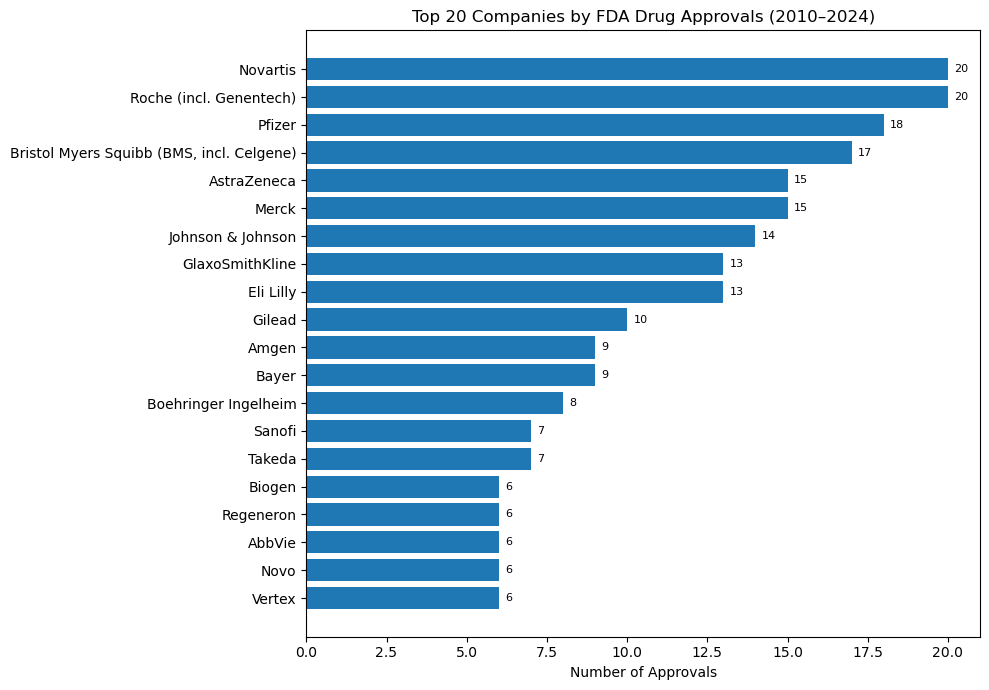

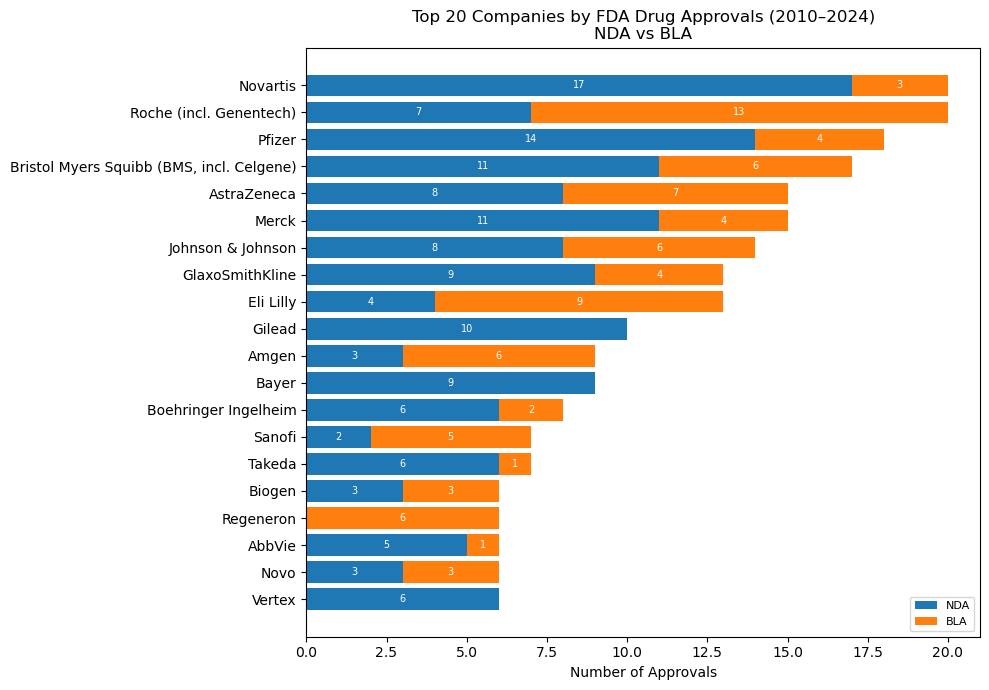


Total approvals 2010–2024: 623
Top 20 grouped companies approvals: 225 (36.1% of all approvals)


In [89]:
## 03 — FDA Drug Approvals by Company (Applicant, 2010–2024)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

# --- 0) Sanity checks & 2010–2024 filter (reuse df from Module 01) ---
assert 'df' in globals(), "Please run Module 01 first so that `df` is defined."
assert 'year_col' in globals(), "`year_col` is not defined. Run Module 01 first."
assert 'FIG_DIR' in globals(), "`FIG_DIR` is not defined. Run Module 01 first."
assert 'DisplayCat' in df.columns, "`DisplayCat` (NDA/BLA) not found. Run Module 01 first."

START_YEAR = globals().get('START_YEAR', 2010)
END_YEAR   = globals().get('END_YEAR', 2024)

df3 = df.copy()
df3[year_col] = pd.to_numeric(df3[year_col], errors="coerce")
df3 = df3[df3[year_col].between(START_YEAR, END_YEAR)].copy()

# --- 1) Detect and clean the 'Applicant' (company) column ---
app_col_candidates = [c for c in df3.columns if "applicant" in c.lower()]
if not app_col_candidates:
    raise ValueError("Could not find an 'Applicant' column in the CSV.")
app_col = app_col_candidates[0]   # usually 'Applicant'
print(f"Using applicant column: {app_col}")

df3[app_col] = df3[app_col].fillna("Unknown").astype(str).str.strip()
df3["DisplayCat"] = df3["DisplayCat"].fillna("NDA")

# --- 2) Group applicants: special keyword rules + first-word fallback ---
def group_applicant(name: str) -> str:
    """
    Group raw applicant names into company buckets.

    Special rules:
    - Any name containing 'celgene' or 'bristol-myers' / 'bristol myers' / 'bms'
        -> 'Bristol Myers Squibb (BMS, incl. Celgene)'
    - Any name containing 'roche' / 'hoffmann-la roche' / 'genentech'
        -> 'Roche (incl. Genentech)'
    - Any name containing 'eli lilly'
        -> 'Eli Lilly'
    - Any name containing 'boehringer ingelheim'
        -> 'Boehringer Ingelheim'
    - Any name containing 'sanofi'
        -> 'Sanofi'
    - Any name containing 'janssen'
        -> 'Johnson & Johnson'
    - Otherwise: use (cleaned) first word as group.
        * If first word is 'The', use the second word instead
          (to avoid meaningless group name 'The').
    """
    raw = str(name).strip()
    s = raw.lower()

    # --- 2.1 Bristol Myers Squibb + Celgene ---
    if ("celgene" in s) or ("bristol-myers" in s) or ("bristol myers" in s) or (" bms" in s):
        return "Bristol Myers Squibb (BMS, incl. Celgene)"

    # --- 2.2 Roche + Genentech ---
    if ("roche" in s) or ("hoffmann-la roche" in s) or ("genentech" in s):
        return "Roche (incl. Genentech)"

    # --- 2.3 Eli Lilly ---
    if "eli lilly" in s:
        return "Eli Lilly"

    # --- 2.4 Boehringer Ingelheim ---
    if "boehringer ingelheim" in s:
        return "Boehringer Ingelheim"

    # --- 2.5 Sanofi / Sanofi-Aventis ---
    if "sanofi" in s:
        return "Sanofi"

    # --- 2.6 Janssen -> Johnson & Johnson ---
    if "janssen" in s:
        return "Johnson & Johnson"

    # --- 2.7 Fallback: use first non-trivial word ---
    if not raw:
        return "Unknown"

    tokens = raw.split()
    if not tokens:
        return "Unknown"

    first = tokens[0].strip(",.")

    # If the name starts with "The", use the second word as the group key
    if first.lower() == "the" and len(tokens) >= 2:
        first = tokens[1].strip(",.")

    return first

df3["Applicant_Group"] = df3[app_col].apply(group_applicant)

# Quick check: distinct counts
print("\nNumber of distinct raw applicants:", df3[app_col].nunique())
print("Number of distinct grouped applicants:", df3["Applicant_Group"].nunique())

# --- 3) Aggregate approvals by grouped company & NDA/BLA ---
company_pivot = (
    df3.groupby(["Applicant_Group", "DisplayCat"])
       .size().reset_index(name="Approvals")
       .pivot(index="Applicant_Group", columns="DisplayCat", values="Approvals")
       .fillna(0).astype(int)
)

# Ensure NDA & BLA columns exist
for col in ["NDA", "BLA"]:
    if col not in company_pivot.columns:
        company_pivot[col] = 0

company_pivot = company_pivot[["NDA", "BLA"]]
company_pivot["Total"] = company_pivot["NDA"] + company_pivot["BLA"]
company_pivot["BLA Share (%)"] = (
    company_pivot["BLA"] / company_pivot["Total"].replace(0, np.nan) * 100
).round(1).fillna(0)

# Sort by total approvals (descending)
company_pivot_sorted = company_pivot.sort_values("Total", ascending=False)

print(f"\n=== Company-level FDA Approvals (grouped) {START_YEAR}–{END_YEAR} ===")
display(company_pivot_sorted.head(30))  # show Top-30 in the notebook

# Save full table to CSV
company_csv_path = FIG_DIR / f"approvals_by_company_grouped_clean_{START_YEAR}_{END_YEAR}.csv"
company_pivot_sorted.to_csv(company_csv_path)
print("Saved full grouped company table to:", company_csv_path)

# --- 4) Mapping raw applicant -> grouped name (for manual review) ---
mapping_df = (
    df3[[app_col, "Applicant_Group"]]
    .drop_duplicates()
    .sort_values("Applicant_Group")
)

mapping_csv_path = FIG_DIR / f"applicant_raw_to_grouped_{START_YEAR}_{END_YEAR}.csv"
mapping_df.to_csv(mapping_csv_path, index=False)
print("Saved raw→grouped mapping to:", mapping_csv_path)

print("\n=== Sample of raw vs grouped applicant names ===")
display(mapping_df.head(50))

# --- 5) Plot 1: Top-20 grouped companies by total approvals (horizontal bar) ---
TOP_N = 20
topN = company_pivot_sorted.head(TOP_N).iloc[::-1]  # largest on top

plt.figure(figsize=(10, 7))
plt.barh(topN.index, topN["Total"])
for y, v in enumerate(topN["Total"]):
    plt.text(v + 0.2, y, str(v), va="center", fontsize=8)
plt.xlabel("Number of Approvals")
plt.title(
    f"Top {TOP_N} Companies by FDA Drug Approvals ({START_YEAR}–{END_YEAR})"
)
plt.tight_layout()
plt.savefig(FIG_DIR / f"company_grouped_clean_top{TOP_N}_total_{START_YEAR}_{END_YEAR}.png", dpi=150)
plt.show()

# --- 6) Plot 2: Top-20 grouped companies, NDA vs BLA (stacked horizontal bar) ---
topN_stack = company_pivot_sorted.head(TOP_N).iloc[::-1]

plt.figure(figsize=(10, 7))
y_pos = np.arange(len(topN_stack))
nda_vals = topN_stack["NDA"].values
bla_vals = topN_stack["BLA"].values

plt.barh(y_pos, nda_vals, label="NDA")
plt.barh(y_pos, bla_vals, left=nda_vals, label="BLA")

for i, (n, b) in enumerate(zip(nda_vals, bla_vals)):
    if n > 0:
        plt.text(n / 2, i, str(n), ha="center", va="center", fontsize=7, color="white")
    if b > 0:
        plt.text(n + b / 2, i, str(b), ha="center", va="center", fontsize=7, color="white")

plt.yticks(y_pos, topN_stack.index)
plt.xlabel("Number of Approvals")
plt.title(
    f"Top {TOP_N} Companies by FDA Drug Approvals ({START_YEAR}–{END_YEAR})\n"
    "NDA vs BLA"
)
plt.legend(loc="lower right", fontsize=8)
plt.tight_layout()
plt.savefig(FIG_DIR / f"company_grouped_clean_top{TOP_N}_nda_bla_stacked_{START_YEAR}_{END_YEAR}.png", dpi=150)
plt.show()

# --- 7) Quick summary text ---
total_approvals = int(company_pivot_sorted["Total"].sum())
topN_approvals = int(topN_stack["Total"].sum())
topN_share = round(topN_approvals / total_approvals * 100, 1)

print(f"\nTotal approvals {START_YEAR}–{END_YEAR}: {total_approvals}")
print(f"Top {TOP_N} grouped companies approvals: {topN_approvals} ({topN_share}% of all approvals)")


## 04 — Trends in Accelerated Approvals (2010–2024)

Rows in 2010–2024 subset: 623

Accelerated approvals (2010–2024):
  Count: 95 out of 623 (15.2%)

=== Accelerated approvals by year (2010–2024) ===


Is_Accelerated,Non-Accelerated,Accelerated,Total,Accelerated Share (%)
Approval Year,,,,
2010,21.0,0.0,21.0,0.0
2011,27.0,3.0,30.0,10.0
2012,35.0,4.0,39.0,10.3
2013,25.0,2.0,27.0,7.4
2014,33.0,8.0,41.0,19.5
2015,39.0,6.0,45.0,13.3
2016,16.0,6.0,22.0,27.3
2017,40.0,6.0,46.0,13.0
2018,55.0,4.0,59.0,6.8


Saved yearly accelerated-approval trend to: /Users/Hanjing1/JupyterProjects/fda-drug-approvals-analysis/figures/accelerated_approvals_by_year_2010_2024.csv


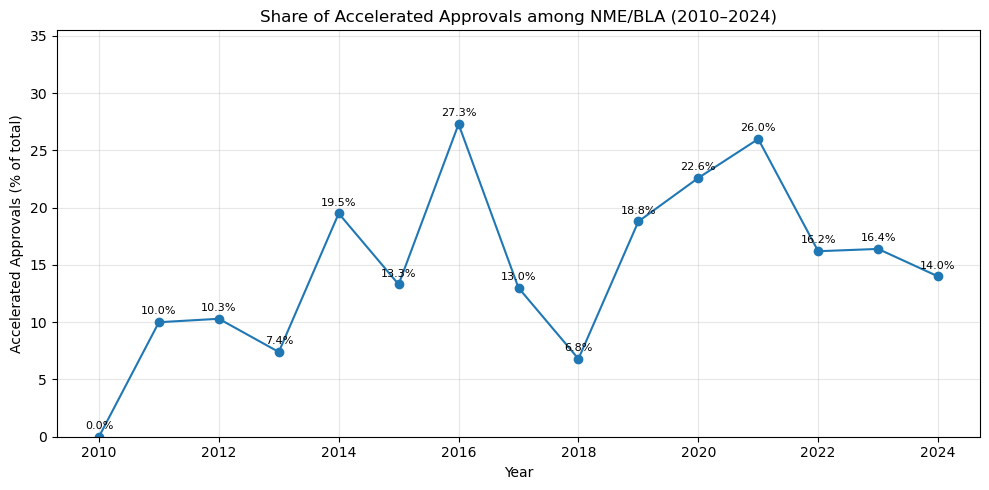

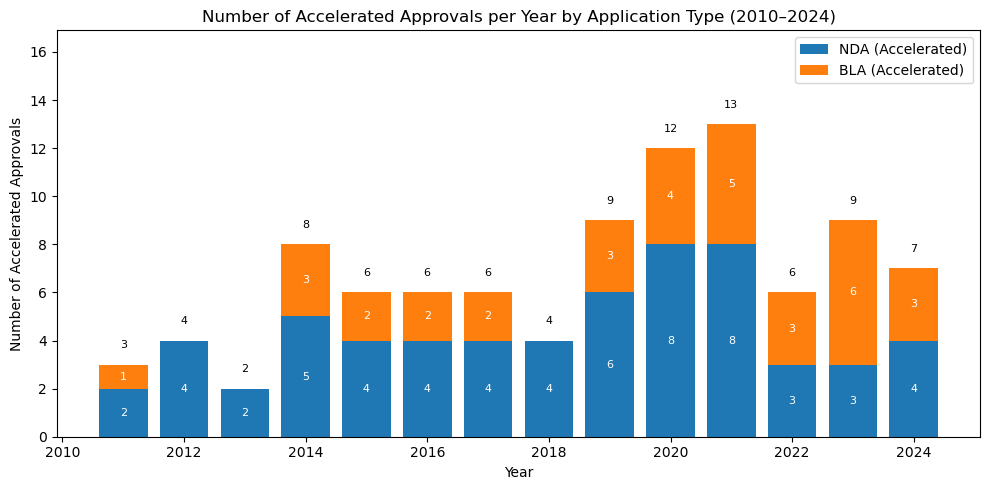


=== Overall summary for accelerated approvals (2010–2024) ===


,Period,Accelerated Approvals,Total Approvals,Accelerated Share (%)
0,2010-2024,95,623,15.2


Saved overall summary to: /Users/Hanjing1/JupyterProjects/fda-drug-approvals-analysis/figures/accelerated_approvals_overall_summary_2010_2024.csv


In [90]:
## 04 — Trends in Accelerated Approvals (2010–2024)

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

# --- 0) Sanity checks & 2010–2024 subset (same 623 drugs) ---
assert 'df' in globals(), "Please run Module 01 first so that `df` is defined."
assert 'year_col' in globals() and year_col in df.columns, "`year_col` is not defined or not in df."
assert 'FIG_DIR' in globals(), "`FIG_DIR` is not defined."
assert 'DisplayCat' in df.columns, "DisplayCat (NDA/BLA) not found. Please run Module 01 first."

START_YEAR = globals().get('START_YEAR', 2010)
END_YEAR   = globals().get('END_YEAR', 2024)

df4 = df.copy()
df4[year_col] = pd.to_numeric(df4[year_col], errors="coerce")
df4 = df4[df4[year_col].between(START_YEAR, END_YEAR)].copy()

print(f"Rows in 2010–2024 subset: {len(df4)}")

# --- 1) Build / reuse Use_Text (for backup text search if needed) ---

def choose_use_text(row):
    """
    Prefer 'Approved Use(s)', fallback to 'Abbreviated Indication(s)' if empty.
    """
    a = row.get("Approved Use(s)")
    b = row.get("Abbreviated Indication(s)")
    a = None if (pd.isna(a) or str(a).strip() == "") else str(a)
    b = None if (pd.isna(b) or str(b).strip() == "") else str(b)
    return a if a is not None else b

if "Use_Text" in df4.columns:
    df4["Use_Text"] = df4["Use_Text"].fillna("").astype(str)
else:
    if ("Approved Use(s)" not in df4.columns) and ("Abbreviated Indication(s)" not in df4.columns):
        raise ValueError("CSV does not contain 'Approved Use(s)' or 'Abbreviated Indication(s)' columns.")
    df4["Use_Text"] = df4.apply(choose_use_text, axis=1).fillna("")

# --- 2) Flag accelerated approvals: use official 'Accelerated Approval' column ---

if "Accelerated Approval" not in df4.columns:
    raise ValueError("Column 'Accelerated Approval' is missing in the CSV.")

# Normalize the Accelerated Approval flag column
acc_col = df4["Accelerated Approval"].astype(str).str.strip().str.lower()

# Primary rule: explicit Yes / Y / 1 / true
df4["Is_Accelerated"] = acc_col.isin(["yes", "y", "1", "true"])

# Optional backup: if flag is false/empty but label text explicitly mentions 'accelerated approval'
df4.loc[
    (~df4["Is_Accelerated"]) &
    df4["Use_Text"].str.contains("accelerated approval", case=False, na=False),
    "Is_Accelerated"
] = True

n_aa = int(df4["Is_Accelerated"].sum())
n_total = len(df4)
aa_share = round(n_aa / n_total * 100, 1) if n_total > 0 else 0

print(f"\nAccelerated approvals (2010–2024):")
print(f"  Count: {n_aa} out of {n_total} ({aa_share}%)")

# --- 3) Trend over time: accelerated approvals by year (for % line) ---

trend = (
    df4.groupby([year_col, "Is_Accelerated"])
       .size().reset_index(name="Count")
       .pivot(index=year_col, columns="Is_Accelerated", values="Count")
       .fillna(0)
       .rename(columns={False: "Non-Accelerated", True: "Accelerated"})
)

# Ensure both columns exist
for col in ["Accelerated", "Non-Accelerated"]:
    if col not in trend.columns:
        trend[col] = 0

trend["Total"] = trend["Accelerated"] + trend["Non-Accelerated"]
trend["Accelerated Share (%)"] = (
    trend["Accelerated"] / trend["Total"].replace(0, np.nan) * 100
).round(1).fillna(0)

print("\n=== Accelerated approvals by year (2010–2024) ===")
display(trend)

# Save yearly trend CSV
aa_trend_csv = FIG_DIR / f"accelerated_approvals_by_year_{START_YEAR}_{END_YEAR}.csv"
trend.to_csv(aa_trend_csv)
print("Saved yearly accelerated-approval trend to:", aa_trend_csv)

# --- 4) Line chart: accelerated approval share (%) over time ---

plt.figure(figsize=(10, 5))

years = trend.index
share = trend["Accelerated Share (%)"]

plt.plot(years, share, marker="o", label="Accelerated approvals (% of total)")

for y, v in zip(years, share):
    plt.text(y, v + 0.5, f"{v}%", ha="center", va="bottom", fontsize=8)

plt.title(f"Share of Accelerated Approvals among NME/BLA ({START_YEAR}–{END_YEAR})")
plt.xlabel("Year")
plt.ylabel("Accelerated Approvals (% of total)")
plt.grid(True, alpha=0.3)
ylim_top = max(share) * 1.3 if len(share) else 10  # extra headroom
plt.ylim(0, ylim_top)
plt.tight_layout()
plt.savefig(FIG_DIR / f"accelerated_approvals_share_line_{START_YEAR}_{END_YEAR}.png", dpi=150)
plt.show()

# --- 5) Bar chart: accelerated approvals per year by NDA vs BLA ---

# Filter to accelerated approvals only
df_aa = df4[df4["Is_Accelerated"]].copy()

# Group by year and DisplayCat (NDA/BLA)
aa_by_type = (
    df_aa.groupby([year_col, "DisplayCat"])
         .size().reset_index(name="Count")
         .pivot(index=year_col, columns="DisplayCat", values="Count")
         .fillna(0)
         .astype(int)
         .sort_index()
)

# Ensure NDA & BLA columns exist
for col in ["NDA", "BLA"]:
    if col not in aa_by_type.columns:
        aa_by_type[col] = 0

aa_by_type = aa_by_type[["NDA", "BLA"]]

plt.figure(figsize=(10, 5))
years2 = aa_by_type.index
nda_vals = aa_by_type["NDA"].values
bla_vals = aa_by_type["BLA"].values
total_vals = nda_vals + bla_vals

# Stacked bar: NDA at bottom, BLA on top
plt.bar(years2, nda_vals, label="NDA (Accelerated)")
plt.bar(years2, bla_vals, bottom=nda_vals, label="BLA (Accelerated)")

# Add labels for NDA/BLA and total per year
for x, n, b, t in zip(years2, nda_vals, bla_vals, total_vals):
    if n > 0:
        plt.text(x, n / 2, str(n), ha="center", va="center", fontsize=8, color="white")
    if b > 0:
        plt.text(x, n + b / 2, str(b), ha="center", va="center", fontsize=8, color="white")
    if t > 0:
        plt.text(x, t + 0.6, str(t), ha="center", va="bottom", fontsize=8)

# Give some extra space on top so labels don't touch the frame
ylim_top2 = max(total_vals) * 1.3 if len(total_vals) else 5
plt.ylim(0, ylim_top2)

plt.title(f"Number of Accelerated Approvals per Year by Application Type ({START_YEAR}–{END_YEAR})")
plt.xlabel("Year")
plt.ylabel("Number of Accelerated Approvals")
plt.legend()
plt.tight_layout()
plt.savefig(FIG_DIR / f"accelerated_approvals_NDA_BLA_stacked_{START_YEAR}_{END_YEAR}.png", dpi=150)
plt.show()

# --- 6) Overall 2010–2024 summary table (accelerated vs total) ---

summary_df = pd.DataFrame(
    {
        "Period":              [f"{START_YEAR}-{END_YEAR}"],
        "Accelerated Approvals": [n_aa],
        "Total Approvals":       [n_total],
        "Accelerated Share (%)": [aa_share],
    }
)

print("\n=== Overall summary for accelerated approvals (2010–2024) ===")
display(summary_df)

summary_csv = FIG_DIR / f"accelerated_approvals_overall_summary_{START_YEAR}_{END_YEAR}.csv"
summary_df.to_csv(summary_csv, index=False)
print("Saved overall summary to:", summary_csv)

## 05 — Trends in Orphan / Breakthrough / Fast Track Designations (2010–2024)

Rows in 2010–2024 subset: 623

Detected designation columns:
  Orphan      : Orphan Drug Designation
  Breakthrough: Breakthrough Therapy Designation
  Fast Track  : Fast Track Designation

2010–2024 overview (N=623 drugs):
  Orphan designation      : 288
  Breakthrough designation: 144
  Fast Track designation  : 232
  Any of the three        : 398

=== Yearly trend: Orphan / Breakthrough / Fast Track (2010–2024) ===


,Orphan,Breakthrough,FastTrack,AnyDesignation,Total,Any Share (%)
Approval Year,,,,,,
2010,6,0,6,9,21,42.9
2011,11,0,13,15,30,50.0
2012,13,0,16,20,39,51.3
2013,9,3,10,14,27,51.9
2014,17,8,16,24,41,58.5
2015,20,10,14,28,45,62.2
2016,9,7,8,14,22,63.6
2017,18,15,16,29,46,63.0
2018,34,14,23,41,59,69.5


Saved yearly designation trend to: /Users/Hanjing1/JupyterProjects/fda-drug-approvals-analysis/figures/designation_trend_by_year_2010_2024.csv


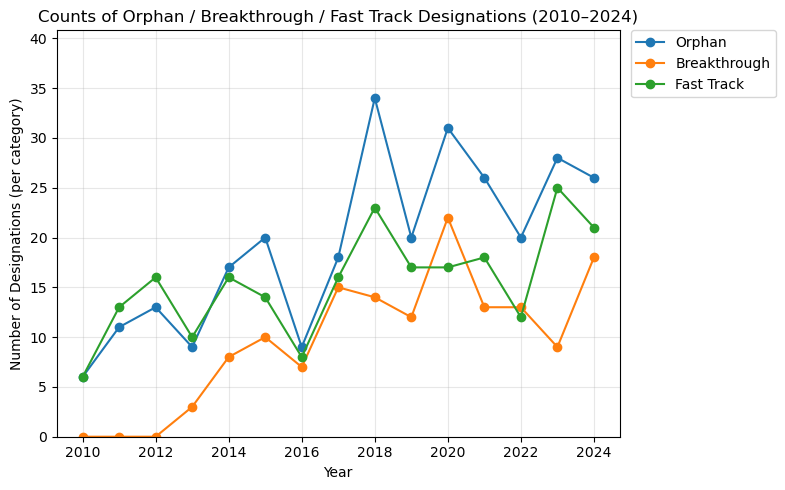

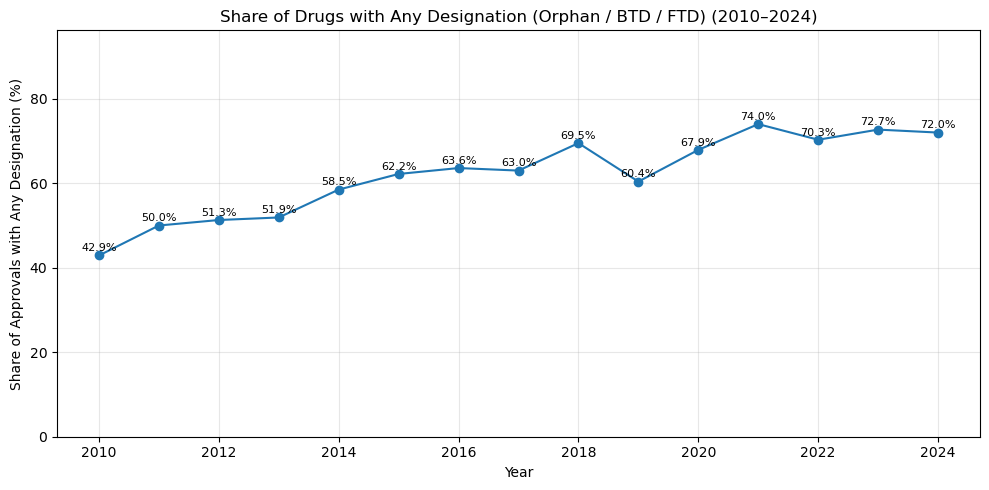


=== Overall combination patterns (2010–2024) ===


,Combination,Drug Count,Share (%)
0,None,225,36.1
1,OF,97,15.6
2,O,84,13.5
3,F,73,11.7
4,OB,62,10.0
5,OBF,45,7.2
6,B,20,3.2
7,BF,17,2.7


Saved designation combination table to: /Users/Hanjing1/JupyterProjects/fda-drug-approvals-analysis/figures/designation_combinations_overall_2010_2024.csv


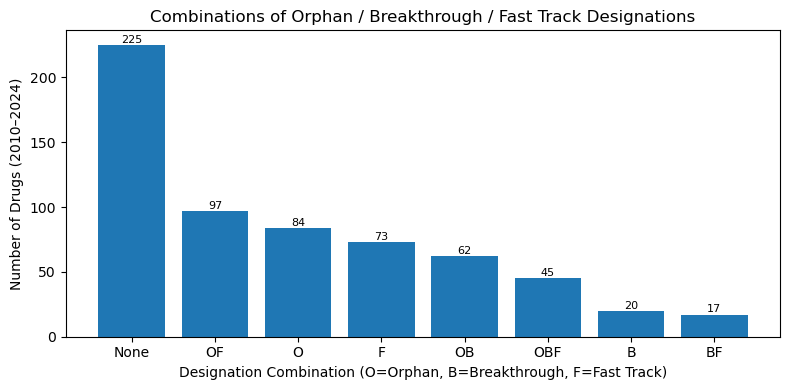


=== Overall summary for designations (2010–2024) ===


,Designation,Drug Count,Share of Approvals (%)
0,Orphan,288,46.2
1,Breakthrough,144,23.1
2,Fast Track,232,37.2
3,Any of the three,398,63.9


Saved overall designation summary to: /Users/Hanjing1/JupyterProjects/fda-drug-approvals-analysis/figures/designation_overall_summary_2010_2024.csv

Triple-designation drugs (O + B + F) in 2010-2024: 45


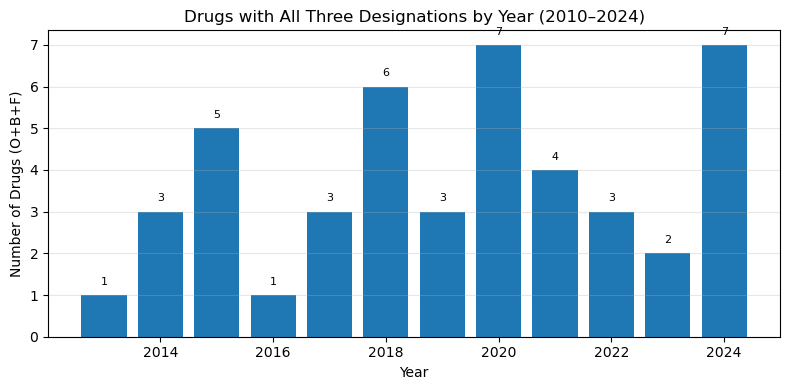


=== Triple-designation drugs by year ===


,Approval Year,Count
0,2013,1
1,2014,3
2,2015,5
3,2016,1
4,2017,3
5,2018,6
6,2019,3
7,2020,7
8,2021,4
9,2022,3



Companies with ≥2 triple-designation drugs (O+B+F):


,Company,Drug Count
0,Vertex Pharmaceuticals,3
1,Alexion Pharmaceuticals,2
2,Genzyme Corporation,2


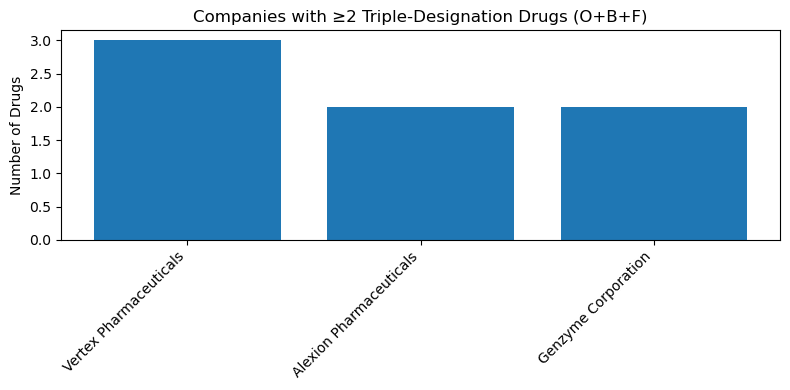


Saved full list of triple-designation drugs to: /Users/Hanjing1/JupyterProjects/fda-drug-approvals-analysis/figures/triple_designation_drugs_list_2010_2024.csv


In [91]:
## 05 — Trends in Orphan / Breakthrough / Fast Track Designations (2010–2024)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

# --- 0) Sanity checks & 2010–2024 subset (same 623 drugs as Module 01) ---

assert 'df' in globals(), "Please run Module 01 first so that `df` is defined."
assert 'year_col' in globals() and year_col in df.columns, "`year_col` is not defined or not in df."
assert 'FIG_DIR' in globals(), "`FIG_DIR` is not defined."

START_YEAR = globals().get('START_YEAR', 2010)
END_YEAR   = globals().get('END_YEAR', 2024)

# Work on a 2010–2024 subset (same convention as other modules)
df5 = df.copy()
df5[year_col] = pd.to_numeric(df5[year_col], errors="coerce")
df5 = df5[df5[year_col].between(START_YEAR, END_YEAR)].copy()

print(f"Rows in 2010–{END_YEAR} subset: {len(df5)}")

# --- 1) Detect the three designation columns (Orphan / Breakthrough / Fast Track) ---

def find_col(df, keyword_list):
    """Return the first column whose name contains any of the given keywords (case-insensitive)."""
    cols = [c for c in df.columns
            if any(k in c.lower() for k in keyword_list)]
    return cols[0] if cols else None

col_orphan = find_col(df5, ["orphan"])
col_btd    = find_col(df5, ["breakthrough"])
col_ftd    = find_col(df5, ["fast track", "fast-track", "fasttrack"])

print("\nDetected designation columns:")
print("  Orphan      :", col_orphan)
print("  Breakthrough:", col_btd)
print("  Fast Track  :", col_ftd)

if col_orphan is None or col_btd is None or col_ftd is None:
    raise ValueError("Could not find one or more of the designation columns "
                     "(Orphan / Breakthrough / Fast Track). Please check the CSV headers.")

# --- 2) Convert columns to boolean flags ---

def to_flag(series):
    """
    Convert a Yes/No-like column to boolean.
    Treat 'yes', 'y', 'true', '1' (case-insensitive) as True; everything else as False.
    """
    s = series.astype(str).str.strip().str.lower()
    return s.isin(["yes", "y", "true", "1"])

df5["Has_Orphan"]       = to_flag(df5[col_orphan])
df5["Has_Breakthrough"] = to_flag(df5[col_btd])
df5["Has_FastTrack"]    = to_flag(df5[col_ftd])

# Any designation: at least one of the three
df5["Has_Any_Designation"] = df5[["Has_Orphan", "Has_Breakthrough", "Has_FastTrack"]].any(axis=1)

n_total = len(df5)
n_orphan = int(df5["Has_Orphan"].sum())
n_btd    = int(df5["Has_Breakthrough"].sum())
n_ftd    = int(df5["Has_FastTrack"].sum())
n_any    = int(df5["Has_Any_Designation"].sum())

print(f"\n2010–{END_YEAR} overview (N={n_total} drugs):")
print(f"  Orphan designation      : {n_orphan}")
print(f"  Breakthrough designation: {n_btd}")
print(f"  Fast Track designation  : {n_ftd}")
print(f"  Any of the three        : {n_any}")

# --- 3) Yearly trend table ---

trend5 = (
    df5.groupby(year_col)
       .agg(
           Orphan=("Has_Orphan", "sum"),
           Breakthrough=("Has_Breakthrough", "sum"),
           FastTrack=("Has_FastTrack", "sum"),
           AnyDesignation=("Has_Any_Designation", "sum"),
           Total=("Has_Any_Designation", "size"),
       )
       .astype(int)
       .sort_index()
)

trend5["Any Share (%)"] = (
    trend5["AnyDesignation"] / trend5["Total"].replace(0, np.nan) * 100
).round(1).fillna(0)

print("\n=== Yearly trend: Orphan / Breakthrough / Fast Track (2010–2024) ===")
display(trend5)

trend5_csv = FIG_DIR / f"designation_trend_by_year_{START_YEAR}_{END_YEAR}.csv"
trend5.to_csv(trend5_csv)
print("Saved yearly designation trend to:", trend5_csv)

# --- 4) Line chart: counts of each designation per year ---

plt.figure(figsize=(10, 5))
years = trend5.index

plt.plot(years, trend5["Orphan"],       marker="o", label="Orphan")
plt.plot(years, trend5["Breakthrough"], marker="o", label="Breakthrough")
plt.plot(years, trend5["FastTrack"],    marker="o", label="Fast Track")

# (Optional) If you want to label each point with its count, uncomment:
# for col in ["Orphan", "Breakthrough", "FastTrack"]:
#     for y, v in zip(years, trend5[col]):
#         if v > 0:
#             plt.text(y, v + 0.5, str(int(v)),
#                      ha="center", va="bottom", fontsize=7)

plt.title(f"Counts of Orphan / Breakthrough / Fast Track Designations ({START_YEAR}–{END_YEAR})")
plt.xlabel("Year")
plt.ylabel("Number of Designations (per category)")
plt.grid(True, alpha=0.3)

# Add some headroom at the top
y_max = trend5[["Orphan", "Breakthrough", "FastTrack"]].values.max()
plt.ylim(0, y_max * 1.2)

# Place legend outside on the right so it does not cover the lines
plt.legend(loc="upper left", bbox_to_anchor=(1.02, 1.0), borderaxespad=0.)
plt.tight_layout(rect=[0, 0, 0.8, 1])  # leave room for legend on the right

plt.savefig(FIG_DIR / f"designation_counts_line_{START_YEAR}_{END_YEAR}.png", dpi=150)
plt.show()

# --- 5) Line chart: share of "any designation" among approvals per year ---

plt.figure(figsize=(10, 5))
share_any = trend5["Any Share (%)"]

plt.plot(years, share_any, marker="o", label="Any designation (% of approvals)")

for y, v in zip(years, share_any):
    plt.text(y, v + 0.5, f"{v}%", ha="center", va="bottom", fontsize=8)

plt.title(f"Share of Drugs with Any Designation (Orphan / BTD / FTD) ({START_YEAR}–{END_YEAR})")
plt.xlabel("Year")
plt.ylabel("Share of Approvals with Any Designation (%)")
plt.grid(True, alpha=0.3)
ylim_top = max(share_any) * 1.3 if len(share_any) else 10
plt.ylim(0, ylim_top)
plt.tight_layout()
plt.savefig(FIG_DIR / f"designation_any_share_line_{START_YEAR}_{END_YEAR}.png", dpi=150)
plt.show()

# --- 6) Combination patterns: O / B / F overlaps (overall 2010–2024) ---

df5["Designation_Combo"] = (
    df5["Has_Orphan"].map({True: "O", False: ""}) +
    df5["Has_Breakthrough"].map({True: "B", False: ""}) +
    df5["Has_FastTrack"].map({True: "F", False: ""})
)
df5["Designation_Combo"] = df5["Designation_Combo"].replace("", "None")

combo_counts = (
    df5["Designation_Combo"]
       .value_counts()
       .rename_axis("Combination")
       .to_frame("Drug Count")
       .reset_index()
)

combo_counts["Share (%)"] = (combo_counts["Drug Count"] / n_total * 100).round(1)

print("\n=== Overall combination patterns (2010–2024) ===")
display(combo_counts)

combo_csv = FIG_DIR / f"designation_combinations_overall_{START_YEAR}_{END_YEAR}.csv"
combo_counts.to_csv(combo_csv, index=False)
print("Saved designation combination table to:", combo_csv)

# Simple bar chart of combination counts
plt.figure(figsize=(8, 4))
plt.bar(combo_counts["Combination"], combo_counts["Drug Count"])
for x, v in zip(combo_counts["Combination"], combo_counts["Drug Count"]):
    plt.text(x, v + 0.2, str(int(v)), ha="center", va="bottom", fontsize=8)
plt.xlabel("Designation Combination (O=Orphan, B=Breakthrough, F=Fast Track)")
plt.ylabel("Number of Drugs (2010–2024)")
plt.title("Combinations of Orphan / Breakthrough / Fast Track Designations")
plt.tight_layout()
plt.savefig(FIG_DIR / f"designation_combinations_bar_{START_YEAR}_{END_YEAR}.png", dpi=150)
plt.show()

# --- 7) Overall summary table (2010–2024) ---

summary5 = pd.DataFrame({
    "Designation": [
        "Orphan",
        "Breakthrough",
        "Fast Track",
        "Any of the three",
    ],
    "Drug Count":  [n_orphan, n_btd, n_ftd, n_any],
})
summary5["Share of Approvals (%)"] = (summary5["Drug Count"] / n_total * 100).round(1)

print("\n=== Overall summary for designations (2010–2024) ===")
display(summary5)

summary5_csv = FIG_DIR / f"designation_overall_summary_{START_YEAR}_{END_YEAR}.csv"
summary5.to_csv(summary5_csv, index=False)
print("Saved overall designation summary to:", summary5_csv)

# --- 8) Deep dive: drugs with all three designations (O + B + F) ---

df_3x = df5[
    df5["Has_Orphan"] &
    df5["Has_Breakthrough"] &
    df5["Has_FastTrack"]
].copy()

print(f"\nTriple-designation drugs (O + B + F) in {START_YEAR}-{END_YEAR}: {len(df_3x)}")

# 8.1 By approval year
triple_by_year = (
    df_3x.groupby(year_col)
         .size()
         .reset_index(name="Count")
         .sort_values(year_col)
)

plt.figure(figsize=(8, 4))
plt.bar(triple_by_year[year_col], triple_by_year["Count"])
for x, v in zip(triple_by_year[year_col], triple_by_year["Count"]):
    plt.text(x, v + 0.2, str(int(v)), ha="center", va="bottom", fontsize=8)
plt.title("Drugs with All Three Designations by Year (2010–2024)")
plt.xlabel("Year")
plt.ylabel("Number of Drugs (O+B+F)")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.savefig(FIG_DIR / "triple_designation_by_year.png", dpi=150)
plt.show()

print("\n=== Triple-designation drugs by year ===")
display(triple_by_year)

# 8.2 Company distribution: use grouped company names from Module 03 if available
if "Applicant_Group" in df_3x.columns:
    company_col = "Applicant_Group"   # cleaned / grouped company labels
else:
    company_col = "Applicant"         # fallback: raw applicant string

comp_triple = (
    df_3x[company_col]
    .astype(str).str.strip()
    .value_counts()
    .rename_axis("Company")
    .to_frame("Drug Count")
    .reset_index()
)

# Keep only companies with more than one triple-designation drug
comp_triple = comp_triple[comp_triple["Drug Count"] > 1]

print("\nCompanies with ≥2 triple-designation drugs (O+B+F):")
if not comp_triple.empty:
    display(comp_triple)

    plt.figure(figsize=(8, 4))
    plt.bar(comp_triple["Company"], comp_triple["Drug Count"])
    plt.xticks(rotation=45, ha="right")
    plt.title("Companies with ≥2 Triple-Designation Drugs (O+B+F)")
    plt.ylabel("Number of Drugs")
    plt.tight_layout()
    plt.savefig(FIG_DIR / "triple_designation_by_company_filtered.png", dpi=150)
    plt.show()
else:
    print("No company has more than one triple-designation drug.")

# 8.3 Optional: save full list of triple-designation drugs for inspection
cols_to_show = [
    "Proprietary  Name",
    "Applicant",
    company_col,
    year_col,
    "Therapeutic_Area",
    col_orphan,
    col_btd,
    col_ftd,
]

triple_list_csv = FIG_DIR / f"triple_designation_drugs_list_{START_YEAR}_{END_YEAR}.csv"
df_3x[cols_to_show].sort_values(year_col).to_csv(triple_list_csv, index=False)
print("\nSaved full list of triple-designation drugs to:", triple_list_csv)

## 06 — Priority Review Voucher Landscape (2010–2024)

Rows in 2010–2024 subset: 623
Using columns:
  Issued PRV   : Issued a Priority Review Voucher
  Redeemed PRV : Redeemed a Priority Review Voucher

=== Issued PRV type counts (2010–2024) ===


,Count
No / None,563
RPD (Rare Pediatric Disease),46
TD (Tropical Disease),9
MTMC (Material Threat MCM),5



=== Redeemed PRV counts (2010–2024) ===


,Count
No,607
Yes,16



Overall (2010–2024):
  • Approvals with a PRV issued : 60 / 623 (9.6%)
  • Approvals that redeemed PRV: 16 / 623 (2.6%)

=== Priority Review Voucher — yearly landscape (2010–2024) ===


,Issued_Count,Redeemed_Count,Total,Issued Share (%),Redeemed Share (%)
Approval Year,,,,,
2010,0,0,21,0.0,0.0
2011,0,0,30,0.0,0.0
2012,1,0,39,2.6,0.0
2013,0,0,27,0.0,0.0
2014,2,0,41,4.9,0.0
2015,5,1,45,11.1,2.2
2016,2,0,22,9.1,0.0
2017,4,1,46,8.7,2.2
2018,8,3,59,13.6,5.1


Saved yearly PRV trend CSV to: /Users/Hanjing1/JupyterProjects/fda-drug-approvals-analysis/figures/prv_trend_2010_2024.csv


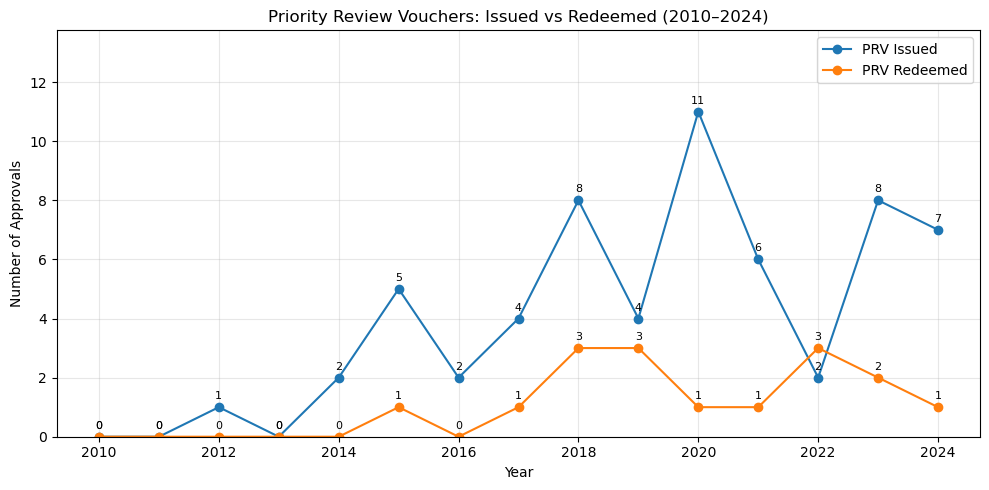

Saved Plot 1 to: /Users/Hanjing1/JupyterProjects/fda-drug-approvals-analysis/figures/prv_issued_vs_redeemed_2010_2024.png

=== Yearly counts by PRV program type (2010–2024) ===


PRV_Issued_Type,MTMC (Material Threat MCM),RPD (Rare Pediatric Disease),TD (Tropical Disease)
Approval Year,,,
2012,0,0,1
2014,0,1,1
2015,0,5,0
2016,0,2,0
2017,0,3,1
2018,1,5,2
2019,0,2,2
2020,3,7,1
2021,0,5,1


Saved PRV-by-type CSV to: /Users/Hanjing1/JupyterProjects/fda-drug-approvals-analysis/figures/prv_issued_by_type_2010_2024.csv


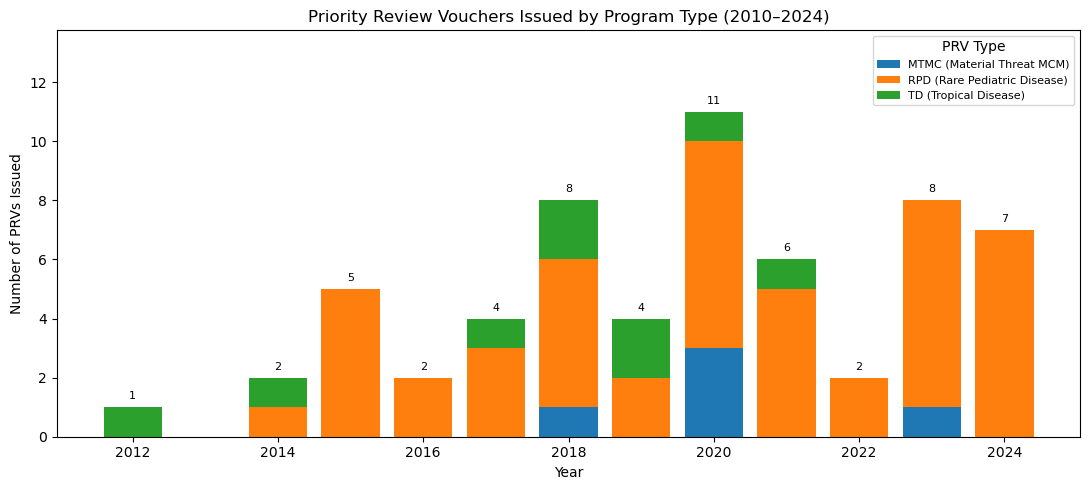

Saved Plot 2 to: /Users/Hanjing1/JupyterProjects/fda-drug-approvals-analysis/figures/prv_issued_by_type_2010_2024.png

=== Overall distribution of PRV types (2010–2024) ===


,PRV Type,Approvals
0,No / None,563
1,RPD (Rare Pediatric Disease),46
2,TD (Tropical Disease),9
3,MTMC (Material Threat MCM),5


Saved overall PRV type table to: /Users/Hanjing1/JupyterProjects/fda-drug-approvals-analysis/figures/prv_type_overall_2010_2024.csv


In [92]:
# === 06 — Priority Review Voucher Landscape (2010–2024) ===

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

# ---------- 0) Sanity checks & 2010–2024 subset ----------

assert 'df' in globals(), "Please run Module 01 first so that `df` is defined."
assert 'FIG_DIR' in globals(), "`FIG_DIR` is not defined."

# Reuse START_YEAR / END_YEAR if available, otherwise default 2010–2024
START_YEAR = globals().get("START_YEAR", 2010)
END_YEAR   = globals().get("END_YEAR", 2024)

# Detect the approval year column again (defensive)
year_col = None
for c in df.columns:
    lc = c.lower()
    if "year" in lc and "approval" in lc:
        year_col = c
        break
if year_col is None:
    for c in df.columns:
        if "year" in c.lower():
            year_col = c
            break
if year_col is None:
    raise ValueError("Could not find an approval year column in df.")

df6 = df.copy()
df6[year_col] = pd.to_numeric(df6[year_col], errors="coerce")
df6 = df6[df6[year_col].between(START_YEAR, END_YEAR)].copy()

print(f"Rows in {START_YEAR}–{END_YEAR} subset: {len(df6)}")

# ---------- 1) Locate PRV-related columns ----------

issued_col = None
redeemed_col = None
for c in df6.columns:
    lc = c.lower()
    if "issued a priority review voucher" in lc:
        issued_col = c
    if "redeemed a priority review voucher" in lc:
        redeemed_col = c

if issued_col is None or redeemed_col is None:
    raise ValueError("Could not find 'Issued a Priority Review Voucher' or 'Redeemed a Priority Review Voucher' columns.")

print("Using columns:")
print("  Issued PRV   :", issued_col)
print("  Redeemed PRV :", redeemed_col)

# ---------- 2) Normalize PRV values (Issued + Redeemed) ----------

def normalize_issued(val: str) -> str:
    """
    Normalize 'Issued a Priority Review Voucher' values into:
    - 'No / None'
    - 'RPD (Rare Pediatric Disease)'
    - 'TD (Tropical Disease)'
    - 'MTMC (Material Threat MCM)'
    - 'Other / Unknown'  (for any unexpected labels)
    """
    if pd.isna(val):
        return "No / None"
    v = str(val).strip().upper()
    if v in {"NO", "N/A", ""}:
        return "No / None"
    if v == "RPD":
        return "RPD (Rare Pediatric Disease)"
    if v == "TD":
        return "TD (Tropical Disease)"
    if v == "MTMC":
        return "MTMC (Material Threat MCM)"
    # Very rare: any other unexpected text
    return "Other / Unknown"

def normalize_redeemed(val: str) -> bool:
    """
    Normalize 'Redeemed a Priority Review Voucher' into a boolean:
    True  = voucher redeemed for this application
    False = not redeemed (No / N/A / blank)
    """
    if pd.isna(val):
        return False
    v = str(val).strip().upper()
    return (v == "YES")

df6["PRV_Issued_Type"] = df6[issued_col].map(normalize_issued)
df6["PRV_Issued_Flag"] = df6["PRV_Issued_Type"].ne("No / None")

df6["PRV_Redeemed"] = df6[redeemed_col].map(normalize_redeemed)

# Quick overview
print("\n=== Issued PRV type counts (2010–2024) ===")
display(df6["PRV_Issued_Type"].value_counts().to_frame("Count"))

print("\n=== Redeemed PRV counts (2010–2024) ===")
display(df6["PRV_Redeemed"].value_counts().rename(
    index={True: "Yes", False: "No"}
).to_frame("Count"))

# Overall stats
n_total = len(df6)
n_issued = int(df6["PRV_Issued_Flag"].sum())
n_redeemed = int(df6["PRV_Redeemed"].sum())

issued_share = round(n_issued / n_total * 100, 1) if n_total else 0
redeemed_share = round(n_redeemed / n_total * 100, 1) if n_total else 0

print(f"\nOverall ({START_YEAR}–{END_YEAR}):")
print(f"  • Approvals with a PRV issued : {n_issued} / {n_total} ({issued_share}%)")
print(f"  • Approvals that redeemed PRV: {n_redeemed} / {n_total} ({redeemed_share}%)")

# ---------- 3) Yearly trend: issued vs redeemed ----------

trend = (
    df6.groupby(year_col)
       .agg(
           Issued_Count   = ("PRV_Issued_Flag", "sum"),
           Redeemed_Count = ("PRV_Redeemed", "sum"),
           Total          = (year_col, "size")
       )
       .astype(int)
       .sort_index()
)

trend["Issued Share (%)"] = (
    trend["Issued_Count"] / trend["Total"].replace(0, np.nan) * 100
).round(1).fillna(0)

trend["Redeemed Share (%)"] = (
    trend["Redeemed_Count"] / trend["Total"].replace(0, np.nan) * 100
).round(1).fillna(0)

print(f"\n=== Priority Review Voucher — yearly landscape ({START_YEAR}–{END_YEAR}) ===")
display(trend)

trend_csv = FIG_DIR / f"prv_trend_{START_YEAR}_{END_YEAR}.csv"
trend.to_csv(trend_csv)
print("Saved yearly PRV trend CSV to:", trend_csv)

# ---------- 4) Plot 1: Issued vs Redeemed counts per year ----------

plt.figure(figsize=(10, 5))
plt.plot(trend.index, trend["Issued_Count"], marker="o", label="PRV Issued")
plt.plot(trend.index, trend["Redeemed_Count"], marker="o", label="PRV Redeemed")

# Add numeric labels
for y, v in zip(trend.index, trend["Issued_Count"]):
    plt.text(y, v + 0.2, str(int(v)), ha="center", va="bottom", fontsize=8)
for y, v in zip(trend.index, trend["Redeemed_Count"]):
    plt.text(y, v + 0.2, str(int(v)), ha="center", va="bottom", fontsize=8)

max_val = max(trend["Issued_Count"].max(), trend["Redeemed_Count"].max()) if len(trend) else 1
plt.ylim(0, max_val * 1.25)

plt.title(f"Priority Review Vouchers: Issued vs Redeemed ({START_YEAR}–{END_YEAR})")
plt.xlabel("Year")
plt.ylabel("Number of Approvals")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()

plot1_path = FIG_DIR / f"prv_issued_vs_redeemed_{START_YEAR}_{END_YEAR}.png"
plt.savefig(plot1_path, dpi=150)
plt.show()
print("Saved Plot 1 to:", plot1_path)

# ---------- 5) Plot 2: Issued PRV by program type per year ----------

issued_df = df6[df6["PRV_Issued_Flag"]].copy()

if len(issued_df) > 0:
    issued_by_type = (
        issued_df.groupby([year_col, "PRV_Issued_Type"])
                 .size().reset_index(name="Count")
                 .pivot(index=year_col, columns="PRV_Issued_Type", values="Count")
                 .fillna(0).astype(int)
                 .sort_index()
    )

    print(f"\n=== Yearly counts by PRV program type ({START_YEAR}–{END_YEAR}) ===")
    display(issued_by_type)

    issued_type_csv = FIG_DIR / f"prv_issued_by_type_{START_YEAR}_{END_YEAR}.csv"
    issued_by_type.to_csv(issued_type_csv)
    print("Saved PRV-by-type CSV to:", issued_type_csv)

    plt.figure(figsize=(11, 5))
    bottom = np.zeros(len(issued_by_type))
    for col in issued_by_type.columns:
        vals = issued_by_type[col].values
        plt.bar(issued_by_type.index, vals, bottom=bottom, label=col)
        bottom += vals

    # Add total labels on top of each bar
    totals = issued_by_type.sum(axis=1)
    for y, v in zip(issued_by_type.index, totals):
        plt.text(y, v + 0.2, str(int(v)), ha="center", va="bottom", fontsize=8)

    max_val2 = totals.max() if len(totals) else 1
    plt.ylim(0, max_val2 * 1.25)

    plt.title(f"Priority Review Vouchers Issued by Program Type ({START_YEAR}–{END_YEAR})")
    plt.xlabel("Year")
    plt.ylabel("Number of PRVs Issued")
    plt.legend(title="PRV Type", fontsize=8)
    plt.tight_layout()

    plot2_path = FIG_DIR / f"prv_issued_by_type_{START_YEAR}_{END_YEAR}.png"
    plt.savefig(plot2_path, dpi=150)
    plt.show()
    print("Saved Plot 2 to:", plot2_path)

else:
    print("\nNo PRVs were issued in this period; skip Plot 2.")

# ---------- 6) Overall program-type distribution (2010–2024) ----------

overall_types = (
    df6["PRV_Issued_Type"]
    .value_counts()
    .rename_axis("PRV Type")
    .to_frame("Approvals")
    .reset_index()
)

print(f"\n=== Overall distribution of PRV types ({START_YEAR}–{END_YEAR}) ===")
display(overall_types)

overall_types_csv = FIG_DIR / f"prv_type_overall_{START_YEAR}_{END_YEAR}.csv"
overall_types.to_csv(overall_types_csv, index=False)
print("Saved overall PRV type table to:", overall_types_csv)